<a href="https://colab.research.google.com/github/terrence-ou/DL_Playground/blob/main/Transformer_From_Scratch_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer from Scratch: English to German Translation

Paper: [Attention is All You Need](https://arxiv.org/abs/1706.03762) \
Dataset: [Multi30K En-De Translation](https://github.com/multi30k/dataset)

Part of this notebook references **The Annotated Transformer** by *Harvard NLP*:\
[The Annotated Transformer](http://nlp.seas.harvard.edu/annotated-transformer/)

# I. Preliminaries

In [ ]:
# Installing these libraries might take ~ 2 min
%%capture
!pip install -q torchdata==0.3.0 torchtext==0.12 spacy==3.2 altair
!pip install torchsummaryX
!python -m spacy download de_core_news_sm
!python -m spacy download en_core_web_sm

In [ ]:
import os
import warnings
import math
import time
from dataclasses import dataclass

from tqdm import tqdm

import pandas as pd

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import log_softmax, pad

import torchtext
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
import torchtext.datasets as datasets

import spacy
import seaborn as sns
import altair as alt # For part of plots
from matplotlib import pyplot as plt

from torchsummaryX import summary

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


In [ ]:
warnings.filterwarnings("ignore")

# In the paper, the batch size was around 25000 and distributed over 8 GPUS
# My batch size is 32 because of my limited CUDA memory
config = dict({"batch_size": 32}) 

# II. Dataset and DataLoaders

### Building vocabularies from datasets

In [ ]:
# The iterator that yields tokenized data
def yield_tokens(data_iter, tokenizer, language):
    assert language in ["en", "de"]
    idx = 0 if language == "en" else 1
    for trans_pair in data_iter:
        yield tokenizer(trans_pair[idx])


# Building vocabulary
def build_vocab(tokenizer_en, tokenizer_de, dataset):
    data_iter = dataset[0] + dataset[1] + dataset[2]
    
    print("Building English Vocabulary...")
    vocab_src = build_vocab_from_iterator(
        yield_tokens(data_iter, tokenizer_en, language="en"),
        min_freq=2,
        specials=["<sos>", "<eos>", "<pad>", "<unk>"]
    )

    print("Building German Vocabulary...")
    vocab_tgt = build_vocab_from_iterator(
        yield_tokens(data_iter, tokenizer_de, language="de"),
        min_freq=2,
        specials=["<sos>", "<eos>", "<pad>", "<unk>"]
    )
    print("Finished")
    return vocab_src, vocab_tgt

In [ ]:
multi30k = torchtext.datasets.Multi30k(language_pair=("en", "de"))
train_data, valid_data, test_data = multi30k

# Tokenizers
spacy_en = spacy.load("en_core_web_sm")
spacy_de = spacy.load("de_core_news_sm")

tokenizer_en = lambda text: [token.text for token in spacy_en.tokenizer(text)]
tokenizer_de = lambda text: [token.text for token in spacy_de.tokenizer(text)]

vocab_src, vocab_tgt = build_vocab(tokenizer_en, tokenizer_de, multi30k)
vocab_src.set_default_index(vocab_src["<unk>"])
vocab_tgt.set_default_index(vocab_tgt["<unk>"])

print(f"Vocabulary sizes: \nEnglish Vocab: {len(vocab_src)}\nGerman Vocab: {len(vocab_tgt)}")

Building English Vocabulary...
Building German Vocabulary...
Finished
Vocabulary sizes: 
English Vocab: 6384
German Vocab: 8315


### Testing Vocabs

In [ ]:
en_text, de_text = next(iter(train_data))
src_map = vocab_src(tokenizer_en(en_text))
tgt_map = vocab_tgt(tokenizer_de(de_text))

print("Source text: ", en_text)
print("Mapped source: ", src_map)
print("\n")
print("Target text: ", de_text) 
print("Mapped target: ", tgt_map)

Source text:  Two young, White males are outside near many bushes.
Mapped source:  [19, 25, 15, 1138, 822, 17, 58, 84, 335, 1359, 5]


Target text:  Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.
Mapped target:  [21, 84, 256, 31, 88, 22, 91, 7, 16, 117, 8211, 3366, 4]


### Creating dataloaders

In [ ]:
# collate class providing collate_fn for batch processing
class Collate():
    def __init__(self, en_tokenizer, de_tokenizer, 
                 vocab_src, vocab_tgt,
                 max_padding=72, pad_idx=2):
        
        self.vocab_src = vocab_src
        self.vocab_tgt = vocab_tgt
        
        self.en_tokenizer = en_tokenizer
        self.de_tokenizer = de_tokenizer
        
        self.max_padding = max_padding
        self.pad_idx = pad_idx
    
    
    def collate_fn(self, batch):
        sos_id = torch.tensor([0])
        eos_id = torch.tensor([1])
        
        src_list, tgt_list = [], []
        
        for src_text, tgt_text in batch:
            # Convert word tokens to vocab indices
            src_mapping = torch.tensor(self.vocab_src(self.en_tokenizer(src_text)), dtype=torch.int64)
            tgt_mapping = torch.tensor(self.vocab_tgt(self.de_tokenizer(tgt_text)), dtype=torch.int64)
            src_mapping = torch.cat([sos_id, src_mapping, eos_id])
            tgt_mapping = torch.cat([sos_id, tgt_mapping, eos_id])

            # pad sequence
            src_padded = pad(src_mapping, [0, self.max_padding - len(src_mapping)], value=self.pad_idx)
            tgt_padded = pad(tgt_mapping, [0, self.max_padding - len(tgt_mapping)], value=self.pad_idx)
            
            src_list.append(src_padded)
            tgt_list.append(tgt_padded)
        
        src = torch.stack(src_list)
        tgt = torch.stack(tgt_list)
        
        return (src, tgt)

In [ ]:
# We need to first conver the dataset to map-style dataset, 
# which has attributes like __len__ and __getitem__
max_padding = 72
pad_idx = vocab_src.get_stoi()["<pad>"]
print(pad_idx)

collate = Collate(tokenizer_en, tokenizer_de, vocab_src, vocab_tgt,
                  max_padding=max_padding, pad_idx=pad_idx)

train_data = to_map_style_dataset(train_data)
valid_data = to_map_style_dataset(valid_data)
test_data = to_map_style_dataset(test_data)

train_loader = DataLoader(train_data, batch_size=config["batch_size"],
                          shuffle=True, num_workers=8, pin_memory=True, collate_fn=collate.collate_fn)
valid_loader = DataLoader(valid_data, batch_size=config["batch_size"],
                          shuffle=False, num_workers=8, pin_memory=True, collate_fn=collate.collate_fn)

2


### Dataloaders sanity check

In [ ]:
#sanity check

for i, data in enumerate(train_loader):
    train_sample = data
    print("Length of sample: ", len(train_sample))
    print("src shape: ", train_sample[0].shape)
    print("tgt shape: ", train_sample[1].shape)

    # Be careful checking if each sequence starts from 0, end with 1, and padded with 2
    print("src sample: ", train_sample[0][0])
    print("tgt sample: ", train_sample[1][0])
    break

Length of sample:  2
src shape:  torch.Size([32, 72])
tgt shape:  torch.Size([32, 72])
src sample:  tensor([   0,    6,  860,   10,  635,   11, 3976,   67,  188,    7,    4,  553,
           5,    1,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
           2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
           2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
           2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
           2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2])
tgt sample:  tensor([   0,    5,  947,   50,  373,    8,    3,   24,   13, 6495,    4,    1,
           2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
           2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
           2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
           2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
      

# III. Transformer Model

## Modules

### Attention
$$\mathrm{Attention}(Q, K, V) = \mathrm{softmax}\left( \frac{QK^{\top}}{\sqrt{d_k}} \right)V$$

In [ ]:
def subsequent_mask(size):
    """
    Mask out subsequent positions
    """
    atten_shape = (1, size, size)
    mask = torch.triu(torch.ones(atten_shape), diagonal=1).type(torch.uint8)
    return mask == 0
    

def attention(query, key, value, mask=None, dropout=None):
    """
    Scaled Dot Product Attention
    """
    d_k = query.shape[-1]
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    
    if mask is not None:
        scores = scores.masked_fill(mask==0, -1e9)
    p_attn = scores.softmax(dim=-1) # Attention
    
    if dropout is not None:
        p_attn = dropout(p_attn)
    
    return torch.matmul(p_attn, value), p_attn

Attention and Mask sanity check

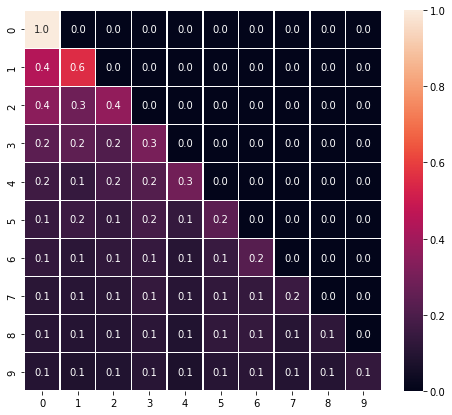

In [ ]:
# attention sanity check
def attn_sanity_check():
    x = torch.rand((1, 10, 10))
    mask = subsequent_mask(10)
    output = attention(x, x, x, mask=mask)[1]
    
    fig, ax = plt.subplots(1, figsize=(8, 7))
    sns.heatmap(output[0], linewidth=.5, ax=ax, annot=True, fmt=".1f")

attn_sanity_check()

### MultiHead Attention

In [ ]:
class MultiHeadAttention(nn.Module):
    
    def __init__(self, h, d_model, dropout=0.1):
        """
        h: number of heads
        d_model: model's dimension
        
        Note: d_model should be divisible by h
        """
        super(MultiHeadAttention, self).__init__()
        assert d_model % h == 0
        
        self.d_k = d_model // h
        self.h = h
        self.key_proj = nn.Linear(d_model, d_model)
        self.query_proj = nn.Linear(d_model, d_model)
        self.value_proj = nn.Linear(d_model, d_model)
        
        self.output_proj = nn.Linear(d_model, d_model)
        
        self.attn = None # stores attention value for visualization
        self.dropout = nn.Dropout(dropout)
    
    
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatch = query.shape[0]
        
        # k, q, v linear projections
        query = self.query_proj(query).reshape(nbatch, -1, self.h, self.d_k).transpose(1, 2)
        key = self.key_proj(key).reshape(nbatch, -1, self.h, self.d_k).transpose(1, 2)
        value = self.value_proj(value).reshape(nbatch, -1, self.h, self.d_k).transpose(1, 2)
        
        # applying attention
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        
        # concatenate x
        x = x.transpose(1, 2).contiguous().view(nbatch, -1, self.h * self.d_k)
        
        del query, key, value
        
        return self.output_proj(x)

### LayerNorm + Skip Connection

In [ ]:
class LayerNorm(nn.Module):
    
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        
        self.w = nn.Parameter(torch.ones(features))
        self.b = nn.Parameter(torch.zeros(features))
        self.eps = eps
    
    def forward(self, x):
        # print("LayerNorm: ", x.shape)
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.w * (x -  mean) / (std + self.eps) + self.b

To facilitate residual connections, all sub-layers, as well as embedding layers, produce outputs of dimension $d_{model}=512$

In [ ]:
class SkipConnection(nn.Module):
    """
    The "Add & Norm" block
    """
    def __init__(self, d_model, dropout):
        super(SkipConnection, self).__init__()
        self.norm = LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, prev_output):
        return self.norm(x + self.dropout(prev_output))

### Feed-Forward Network

In [ ]:
class FeedForward(nn.Module):
    
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.dropout(self.linear1(x).relu())
        return self.linear2(x)

### Embedding and Positional Encoding

In [ ]:
class Embeddings(nn.Module):
    
    def __init__(self, d_model, vocab_size):
        super(Embeddings, self).__init__()
        self.emb = nn.Embedding(vocab_size, d_model)
        self.d_model = d_model
    
    def forward(self, x):
        return self.emb(x) * math.sqrt(self.d_model)

Equations for positional encoding:
$$PE_{pos, 2i} = \sin (pos / 10000^{2i/d_{model}})$$
$$PE_{pos, 2i+1} = \cos (pos / 10000^{2i/d_{model}})$$

In [ ]:
class PositionalEncoding(nn.Module):
    
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
                        torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
                    )
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0) # Adding "Batch" dimenssion
        self.register_buffer("pe", pe) # Adding "PE" to the model's parameter dict
        
    def forward(self, x):
        x = x + self.pe[:, : x.size(1)].requires_grad_(False) # Making PE not learnable
        return self.dropout(x)

Positional Encoding Check

In [ ]:
pe = PositionalEncoding(20, 0)
y = pe.forward(torch.zeros(1, 100, 20))

data = pd.concat([
        pd.DataFrame({
            "embedding": y[0, :, dim], 
            "dimension": dim,
            "position": list(range(100))
        })
        for dim in [4, 5, 6, 7]
    ])

alt.Chart(data).mark_line()\
    .properties(width=600)\
    .encode(x="position", y="embedding", color="dimension:N")

alt.Chart(...)

## Encoder
The Encoder is composed of $N=6$ identical layers

In [ ]:
class Encoder_layer(nn.Module):
    
    def __init__(self, d_model, heads, d_ff, dropout=0.1):
        super(Encoder_layer, self).__init__()
        
        self.d_model = d_model
        
        self.attention = MultiHeadAttention(heads, d_model, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.add_norm_1 = SkipConnection(d_model, dropout)
        self.add_norm_2 = SkipConnection(d_model, dropout)
    
    
    def forward(self, x, mask=None):
        # print("Init input: ", x.shape)
        attn = self.attention(x, x, x, mask)
        x = self.add_norm_1(x, attn)
        # print("attn shape", attn.shape)
        ff = self.feed_forward(x)
        # print("ff shape: ", ff.shape)
        x = self.add_norm_2(x, ff)
        return x      

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, N, d_model, heads, d_ff, dropout=0.1):
        super(Encoder, self).__init__()
        # Adding encoder layers
        self.layers = nn.Sequential(
                *[Encoder_layer(d_model, heads, d_ff, dropout) for _ in range(N)]
            )
        self.norm = LayerNorm(d_model)
    

    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

# encoder = Encoder(6, 512, 8, 2048, 0.1)
# summary(encoder, (10, 512))
# del encoder

## Decoder
The Decoder is also composed of $N=6$ identical layers

In [ ]:
class Decoder_layer(nn.Module):
    
    def __init__(self, d_model, heads, d_ff, dropout=0.1):
        super(Decoder_layer, self).__init__()
        self.d_model = d_model
        
        self.self_attention = MultiHeadAttention(heads, d_model, dropout)
        self.add_norm_1 = SkipConnection(d_model, dropout)
        
        self.src_attention = MultiHeadAttention(heads, d_model, dropout)
        self.add_norm_2 = SkipConnection(d_model, dropout)
        
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.add_norm_3 = SkipConnection(d_model, dropout)
    
    
    def forward(self, x, encoder_output, src_mask=None, tgt_mask=None):
        
        self_attn = self.self_attention(x, x, x, tgt_mask)
        x = self.add_norm_1(x, self_attn)
        
        src_attn = self.src_attention(x, encoder_output, encoder_output, src_mask)
        x = self.add_norm_2(x, src_attn)
        
        ff = self.feed_forward(x)
        x = self.add_norm_3(x, ff)
        
        return x

In [ ]:
class Decoder(nn.Module):
    
    def __init__(self, N, d_model, heads, d_ff, dropout=0.1):
        super(Decoder, self).__init__()
        self.layers = nn.Sequential(
                *[Decoder_layer(d_model, heads, d_ff, dropout) for _ in range(N)]
            )
        self.norm = LayerNorm(d_model)
    
    
    def forward(self, x, encoder_output, src_mask=None, tgt_mask=None):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x)

# decoder = Decoder(6, 512, 8, 2048, 0.1)  
# summary(decoder, input_data=[torch.ones(1, 10, 512), torch.ones(1, 10, 512)])
# del decoder

## Transformer
Putting Embedding, Positional Encoding, Encoder, and decoder together

In [ ]:
class Transformer(nn.Module):
    
    def __init__(self, src_vocab_size, tgt_vocab_size, N, d_model, heads, d_ff, dropout=0.1):
        super(Transformer, self).__init__()
        
        # Encoder Embedding and Postional Encoding
        self.src_em_pe = nn.Sequential(
                                Embeddings(d_model, src_vocab_size),
                                PositionalEncoding(d_model, dropout=dropout, max_len=500),
                            )
        
        # Decoder Embedding and Positional Encoding
        self.tgt_em_pe = nn.Sequential(
                                Embeddings(d_model, tgt_vocab_size),
                                PositionalEncoding(d_model, dropout=dropout, max_len=500),
                            )
        
        # Encoder
        self.encoder = Encoder(N, d_model, heads, d_ff, dropout)
        
        # Decoder
        self.decoder = Decoder(N, d_model, heads, d_ff, dropout)
        
        # Output layer
        self.output = nn.Sequential(
                            nn.Linear(d_model, tgt_vocab_size),
                            nn.LogSoftmax(dim=-1)
                        )
        
    # Encoding
    def encode(self, x_src, src_mask=None):
        x_src = self.src_em_pe(x_src)
        return self.encoder(x_src, src_mask)
    
    # Decoding
    def decode(self, x_tgt, encoder_output, src_mask=None, tgt_mask=None):
        x_tgt = self.tgt_em_pe(x_tgt)
        return self.decoder(x_tgt, encoder_output, src_mask, tgt_mask)
    
    def forward(self, x_src, x_tgt, src_mask=None, tgt_mask=None):
        encoder_output = self.encode(x_src, src_mask)
        decoder_output = self.decode(x_tgt, encoder_output, src_mask, tgt_mask)
        return self.output(decoder_output)

In [ ]:
# model = Transformer(100, 100, 6, 512, 8, 2048, 0.1)
# summary(model, torch.ones(1, 10).type(torch.LongTensor), torch.ones(1, 10).type(torch.LongTensor))
# del model

---

# IV. Training Setup

In [ ]:
config = {
    "batch_size": 32,
    "d_model": 512,
    "src_vocab_size": len(vocab_src),
    "tgt_vocab_size": len(vocab_tgt),
    "num_layers": 6,
    "heads": 8,
    "d_ff": 2048,
    "dropout": 0.25,
    "epoch": 10
}

### Model

In [ ]:
model = Transformer(src_vocab_size=config["src_vocab_size"], 
                    tgt_vocab_size=config["tgt_vocab_size"],
                    N=config["num_layers"], 
                    d_model=config["d_model"], 
                    heads=config["heads"],
                    d_ff=config["d_ff"], 
                    dropout=config["dropout"])

model = model.to(DEVICE)
# summary(model, torch.ones(1, 64).type(torch.LongTensor).to(DEVICE), 
#                 torch.ones(1, 63).type(torch.LongTensor).to(DEVICE))

### Criterion, Optimizer, LR Scheduler

According to the paper, the varied learning rate is according to the formula:
$$lrate = d_{model}^{-0.5} \cdot \min (step\_num^{-0.5}, step\_num \cdot warmup\_steps^{-1.5})$$
with $warmup\_steps = 4000$

In [ ]:
def lrate(step, d_model, warmup_step=4000):
    step = max(1, step)
    lr = d_model ** (-0.5) * min(step ** (-0.5), step * warmup_step ** (-1.5))
    return lr

In [ ]:
# lrate visualize
warmup_steps = [4000, 8000]
lrs = [
        [lrate(i, 512, warmup_step=steps) for i in range(20000)] for steps in warmup_steps
      ]
lr_data = pd.concat([
             pd.DataFrame({
                 "Learning Rate": lrs[i],
                 "Step": list(range(20000)),
                 "Warmup_Steps": str(warmup_steps[i])
             }) for i in range(2)
            ]
        )

alt.data_transformers.disable_max_rows()
alt.Chart(lr_data).mark_line().properties(width=600)\
    .encode(x="Step", y="Learning Rate", color="Warmup_Steps")

alt.Chart(...)

In [ ]:
# Reference: http://nlp.seas.harvard.edu/annotated-transformer/
class LabelSmoothing(nn.Module):
    
    def __init__(self, size, pad_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction="sum")
        self.padding_idx = pad_idx

        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        
        self.size = size
        self.true_dist = None
    

    def forward(self, x, target):

        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)

        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        
        return self.criterion(x, true_dist.clone().detach())

In [ ]:
class Smoothed_KLDiv_Loss:
    
    def __init__(self, criterion):
        self.criterion = criterion
    
    def __call__(self, x, y, norm):
        sloss = (
            self.criterion(x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1)) / norm
        )
        return sloss.data * norm, sloss

In [ ]:
loss_fn = LabelSmoothing(
        size=len(vocab_tgt), pad_idx=2, smoothing=0.1
    )

criterion = Smoothed_KLDiv_Loss:(loss_fn)

# criterion = nn.CrossEntropyLoss(ignore_index=2, 
#                                 reduction="sum",
#                                 label_smoothing=0.1)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.5, betas=(0.9, 0.98), eps=1e-9, amsgrad=True)
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                                 lr_lambda=lambda step: lrate(step, d_model=config["d_model"], warmup_step=1000))
scaler = torch.cuda.amp.GradScaler()

In [ ]:
@dataclass
class TrainState:
    """
    The TrainState class tracks the number of steps in trainig
    """
    step: int = 0
    accum_step: int = 0

### Train and Validation functions

In [ ]:
# getting data and masks
def get_inputs(src, tgt=None, pad_idx=2):
    src_mask = (src != pad_idx).unsqueeze(-2)
    
    if tgt is not None:
        tgt_in = tgt[:, :-1]
        tgt_y = tgt[:, 1:]
        
        tgt_mask = (tgt_in != pad_idx).unsqueeze(-2)
        tgt_mask = tgt_mask & subsequent_mask(tgt_in.shape[-1]).type_as(tgt_mask.data)
        
        return src, tgt_in, tgt_y, src_mask, tgt_mask

    return src, src_mask

def get_token_num(tgt_y):
    return torch.sum(tgt_y != 2).sum()

# mask sanity check
for i, (src, tgt) in enumerate(train_loader):
    inputs = get_inputs(src, tgt)
    print("src shape: ", inputs[0].shape)
    print("tgt_in shape: ", inputs[1].shape)
    print("tgt_y shape: ", inputs[2].shape)
    print("src_mask shape: ", inputs[3].shape)
    print("tgt_mask shape: ", inputs[4].shape)
    break

src shape:  torch.Size([32, 72])
tgt_in shape:  torch.Size([32, 71])
tgt_y shape:  torch.Size([32, 71])
src_mask shape:  torch.Size([32, 1, 72])
tgt_mask shape:  torch.Size([32, 71, 71])


In [ ]:
def train(dataloader, model, criterion, optimizer, scheduler, scaler, train_state):
    
    model.train()
    total_loss = 0
    total_tokens = 0
    
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, desc="Train", leave=False)
    
    for i, (src, tgt) in enumerate(dataloader):
        
        optimizer.zero_grad()
        curr_lr = optimizer.param_groups[0]["lr"]
        
        inputs = get_inputs(src, tgt)
        src, tgt, tgt_y, src_mask, tgt_mask = [item.to(DEVICE) for item in inputs]
        norm = get_token_num(tgt_y)
        
        y_pred = model(src, tgt, src_mask, tgt_mask)

        # Loss
        loss, loss_node = criterion(y_pred, tgt_y, norm)
                            
        total_loss += loss.item()
        total_tokens += norm.item()
        
        train_state.step += 1
        
        # Backward propagation
        scaler.scale(loss_node).backward()
        scaler.step(optimizer)
        scaler.update()
        
        scheduler.step()
        
        batch_bar.set_postfix(
            loss = f"{total_loss / total_tokens:.4f}",
            lr = f"{curr_lr:.6f}"
        )
        
        batch_bar.update()

        torch.cuda.empty_cache()
        del src, tgt, tgt_y, src_mask, tgt_mask

    batch_bar.close()
    
    return total_loss / total_tokens

In [ ]:
def validate(dataloader, model, criterion):
    
    model.eval()
    total_loss = 0
    total_tokens = 0
    
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, desc="Valid", leave=False)
    
    for i, (src, tgt) in enumerate(dataloader):
        
        with torch.no_grad():
            inputs = get_inputs(src, tgt)
            src, tgt, tgt_y, src_mask, tgt_mask = [item.to(DEVICE) for item in inputs]
            norm = get_token_num(tgt_y)
            
            
            y_pred = model(src, tgt, src_mask, tgt_mask)
            loss, loss_node = criterion(y_pred, tgt_y, norm)
                    
        total_loss += loss.item()
        total_tokens += norm.item()

        batch_bar.set_postfix(
            loss = f"{total_loss / total_tokens:.4f}")
        
        batch_bar.update()

        torch.cuda.empty_cache()
        del src, tgt, tgt_y, src_mask, tgt_mask
        
    batch_bar.close()
    
    return total_loss / total_tokens

---

# V. Training

In [ ]:
lowest_loss = torch.inf
train_loss_hist = []
valid_loss_hist = []

train_state = TrainState()
for i in range(config["epoch"]):
    start_time = time.time()
    
    train_loss = train(train_loader, model, criterion, optimizer, lr_scheduler, scaler, train_state)
    valid_loss = validate(valid_loader, model, criterion)
    
    train_loss_hist.append(train_loss)
    valid_loss_hist.append(valid_loss)
    
    lr = optimizer.param_groups[0]["lr"]
    
    print(f"Epoch: {i+1}/{config['epoch']}\tTrain loss: {train_loss:.4f}\tValid loss: {valid_loss:.4f}\
            \n\t\tlr: {lr:.6f}\ttime: {(time.time() - start_time)/60:.1f} min\ttotal step: {train_state.step}")
    
    # Saving model
    if valid_loss < lowest_loss:
        lowest_loss = valid_loss
        print("Saving model")
        torch.save({"model_state_dict":model.state_dict()}, "./transformer_checkpoint.pth")
        

Epoch: 1/10	Train loss: 3.7224	Valid loss: 2.8330            
		lr: 0.000634	time: 4.8 min	total step: 907
Saving model


Epoch: 2/10	Train loss: 2.5423	Valid loss: 2.2710            
		lr: 0.000519	time: 5.0 min	total step: 1814
Saving model


Epoch: 3/10	Train loss: 2.1322	Valid loss: 2.0398            
		lr: 0.000424	time: 5.0 min	total step: 2721
Saving model


Epoch: 4/10	Train loss: 1.8897	Valid loss: 1.8920            
		lr: 0.000367	time: 5.0 min	total step: 3628
Saving model


Epoch: 5/10	Train loss: 1.7276	Valid loss: 1.7953            
		lr: 0.000328	time: 5.0 min	total step: 4535
Saving model


Epoch: 6/10	Train loss: 1.5986	Valid loss: 1.7571            
		lr: 0.000300	time: 5.0 min	total step: 5442
Saving model


Epoch: 7/10	Train loss: 1.4975	Valid loss: 1.7015            
		lr: 0.000277	time: 5.0 min	total step: 6349
Saving model


Epoch: 8/10	Train loss: 1.4100	Valid loss: 1.6582            
		lr: 0.000259	time: 5.0 min	total step: 7256
Saving model


Epoch: 9/10	Train loss: 1.3324	Valid loss: 1.6187            
		lr: 0.000245	time: 5.0 min	total step: 8163
Saving model


Epoch: 10/10	Train loss: 1.2665	Valid loss: 1.6106            
		lr: 0.000232	time: 5.0 min	total step: 9070
Saving model


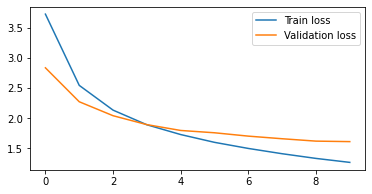

In [ ]:
plt.figure(figsize=(6, 3))
plt.plot(train_loss_hist, label="Train loss")
plt.plot(valid_loss_hist, label="Validation loss")
plt.legend()
plt.show()

---

# VI. Results

In [ ]:
best_state = torch.load("./transformer_checkpoint.pth")
print(best_state.keys())
model.load_state_dict(best_state["model_state_dict"])

dict_keys(['model_state_dict'])


<All keys matched successfully>

In [ ]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    
    model.eval()
    ys = torch.zeros(1, 1).fill_(start_symbol).type_as(src.data)
    
    for i in range(max_len - 1):
        tgt_mask = subsequent_mask(ys.shape[1]).type_as(src.data)
        output = model(src, ys.unsqueeze(0), src_mask, tgt_mask)

        _, next_word = torch.max(output, dim=-1)
        next_word = next_word[0, 0, -1] # Newly generated word

        # Add new word to the previous sequence for the next iteration
        ys = torch.cat(
            [ys, torch.zeros(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )
    return ys

### check generated outputs

In [ ]:
def vocab_to_str(output, vocab):
    idcs = output.detach().cpu().numpy().reshape(-1)
    txt = " ".join([vocab.get_itos()[x] for x in idcs if x != pad and x != 0])
    txt = "<sos> " + txt.split("<eos>")[0] + "<eos>"
    return txt

In [ ]:
# Test dataloader. For the purpose of result checking, 
# we can set `shuffle=True`
test_loader = DataLoader(test_data, batch_size=64,
                          shuffle=True, collate_fn=collate.collate_fn)

num_outputs = 4

In [ ]:
model.eval()
data = next(iter(test_loader))
inputs = get_inputs(data[0], data[1])

for i in range(num_outputs):
    print(f"\nExample {i+1} ======\n")
    src, tgt, tgt_y, src_mask, tgt_mask = [item[i].unsqueeze(0).to(DEVICE) for item in inputs]
    generated = greedy_decode(model, src, src_mask, 64, 0)
    
    src_text = vocab_to_str(src, vocab_src)
    tgt_y_text = vocab_to_str(tgt_y, vocab_tgt)
    generated_text = vocab_to_str(generated, vocab_tgt)
    
    print(f"Source Text (EN):\t{src_text}")
    print(f"Ground Truth (DE):\t{tgt_y_text}")
    print(f"Model Generated (DE):\t{generated_text}")


Example 1 ======

Source Text (EN):	<sos> A man riding his bike up the ramp . <eos>
Ground Truth (DE):	<sos> Ein Mann fährt sein Fahrrad die Rampe hoch . <eos>
Model Generated (DE):	<sos> Ein Mann fährt mit seinem Fahrrad die Rampe hoch . <eos>

Example 2 ======

Source Text (EN):	<sos> There are two dogs in the snow and one has something in his mouth . <eos>
Ground Truth (DE):	<sos> Zwei Hunde sind im Schnee , einer von ihnen hat etwas im Maul . <eos>
Model Generated (DE):	<sos> Zwei Hunde sind im Schnee , einer hat etwas im Schnee und der andere hat etwas im Maul . <eos>

Example 3 ======

Source Text (EN):	<sos> Three construction workers are <unk> pavement . <eos>
Ground Truth (DE):	<sos> Drei Arbeiter machen <unk> auf dem Gehsteig . <eos>
Model Generated (DE):	<sos> Drei Bauarbeiter <unk> auf dem Gehweg . <eos>

Example 4 ======

Source Text (EN):	<sos> A little girl in a purple plaid dress is lying on the floor crying . <eos>
Ground Truth (DE):	<sos> Ein kleines Mädchen in einem

### Visualizing Attentions

In [ ]:
def plot_attn(attn, head, row_txt, col_txt, ax):
    
    row_tokens = row_txt.split(" ")
    col_tokens = col_txt.split(" ")
    
    vis_attn = attn[0, head, :len(row_tokens), :len(col_tokens)].detach().cpu().numpy()
    
    return sns.heatmap(vis_attn, xticklabels=col_tokens, yticklabels=row_tokens, ax=ax)

#### Decoder src attention

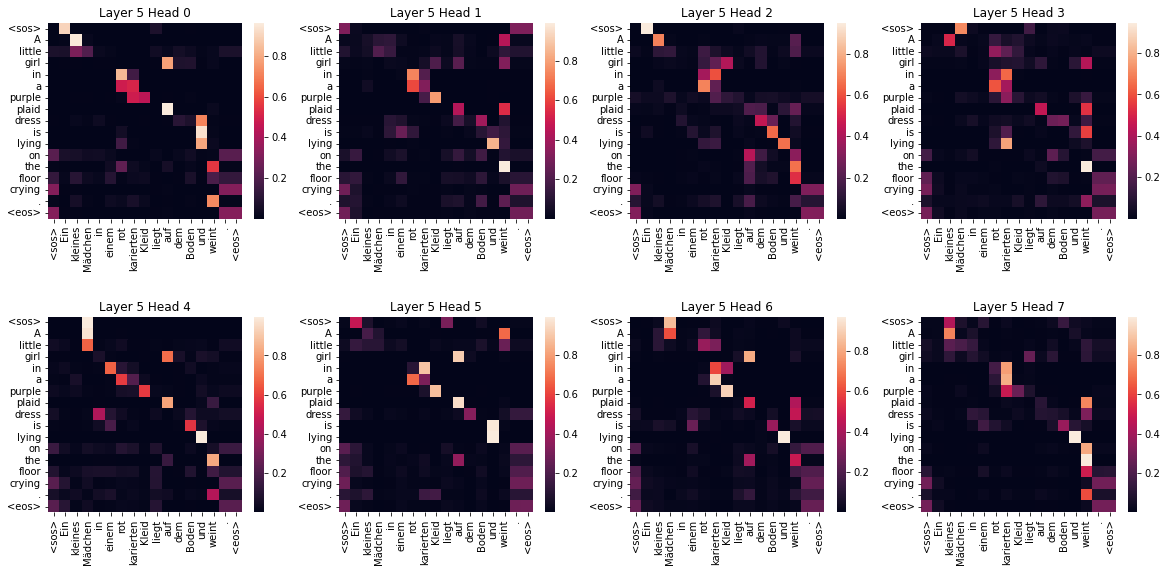

In [ ]:
LAYER = 5
attn_to_vis = model.decoder.layers[LAYER].src_attention.attn
x_tick = tgt_y_text
y_tick = src_text

fig, axes = plt.subplots(2, 4, figsize=(20, 9))
plt.subplots_adjust(hspace=0.5)


for r in range(2):
    for c in range(4): 
        head = r * 4 + c
        axes[r, c].set_title(f"Layer {LAYER} Head {head}")
        decoder_attn = attn_to_vis
        plot_attn(decoder_attn, head, y_tick, x_tick, axes[r, c])
plt.show()

Decoder self attention

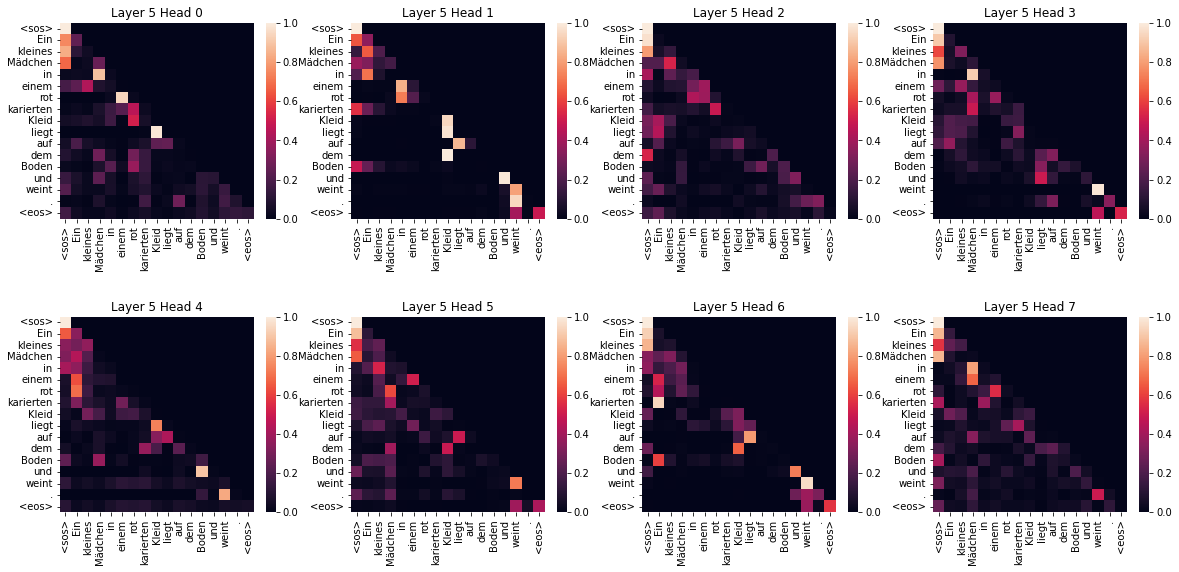

In [ ]:
LAYER = 5
attn_to_vis = model.decoder.layers[LAYER].self_attention.attn
x_tick = tgt_y_text
y_tick = tgt_y_text

fig, axes = plt.subplots(2, 4, figsize=(20, 9))
plt.subplots_adjust(hspace=0.5)


for r in range(2):
    for c in range(4): 
        head = r * 4 + c
        axes[r, c].set_title(f"Layer {LAYER} Head {head}")
        decoder_attn = attn_to_vis
        plot_attn(decoder_attn, head, y_tick, x_tick, axes[r, c])
plt.show()